<a href="https://colab.research.google.com/github/Vimp17/py/blob/main/Unet_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

# Укажите путь к архиву и папку для распаковки
archive_path = '/content/dataset_seg.zip'  # Пример: '/content/drive/MyDrive/archive.zip'
extract_folder = '/content'

# Распаковка
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Архив успешно распакован!")

In [5]:
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.utils.data as data
import torchvision
from torchvision import models
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim


class SegmentDataset(data.Dataset):
    def __init__(self, path, transform_img=None, transform_mask=None):
        self.path = path
        self.transform_img = transform_img
        self.transform_mask = transform_mask

        path = os.path.join(self.path, 'images')
        list_files = os.listdir(path)
        self.length = len(list_files)
        self.images = list(map(lambda _x: os.path.join(path, _x), list_files))

        path = os.path.join(self.path, 'masks')
        list_files = os.listdir(path)
        self.masks = list(map(lambda _x: os.path.join(path, _x), list_files))

    def __getitem__(self, item):
        path_img, path_mask = self.images[item], self.masks[item]
        img = Image.open(path_img).convert('RGB')
        mask = Image.open(path_mask).convert('L') # grayscale

        if self.transform_img:
            img = self.transform_img(img)

        if self.transform_mask:
            mask = self.transform_mask(mask)
            mask[mask < 250] = 1
            mask[mask >= 250] = 0

        return img, mask

    def __len__(self):
        return self.length


class UNetModel(nn.Module):
    class _TwoConvLayers(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
            )

        def forward(self, x):
            return self.model(x)

    class _EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.block = UNetModel._TwoConvLayers(in_channels, out_channels)
            self.max_pool = nn.MaxPool2d(2)

        def forward(self, x):
            x = self.block(x)
            y = self.max_pool(x)
            return y, x

    class _DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.transpose = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
            self.block = UNetModel._TwoConvLayers(in_channels, out_channels)

        def forward(self, x, y):
            x = self.transpose(x)
            u = torch.cat([x, y], dim=1)
            u = self.block(u)
            return u

    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.enc_block1 = self._EncoderBlock(in_channels, 64)
        self.enc_block2 = self._EncoderBlock(64, 128)
        self.enc_block3 = self._EncoderBlock(128, 256)
        self.enc_block4 = self._EncoderBlock(256, 512)

        self.bottleneck = self._TwoConvLayers(512, 1024)

        self.dec_block1 = self._DecoderBlock(1024, 512)
        self.dec_block2 = self._DecoderBlock(512, 256)
        self.dec_block3 = self._DecoderBlock(256, 128)
        self.dec_block4 = self._DecoderBlock(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        x, y1 = self.enc_block1(x)
        x, y2 = self.enc_block2(x)
        x, y3 = self.enc_block3(x)
        x, y4 = self.enc_block4(x)

        x = self.bottleneck(x)

        x = self.dec_block1(x, y4)
        x = self.dec_block2(x, y3)
        x = self.dec_block3(x, y2)
        x = self.dec_block4(x, y1)

        return self.out(x)


class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num = targets.size(0)
        probs = nn.functional.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2 * (intersection.sum(1) + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        score = 1 - score.sum() / num
        return score

tr_img = tfs_v2.Compose([tfs_v2.ToImage(), tfs_v2.ToDtype(torch.float32, scale=True)])
tr_mask = tfs_v2.Compose([tfs_v2.ToImage(), tfs_v2.ToDtype(torch.float32)])


In [ ]:
d_train = SegmentDataset("/content/dataset_seg", transform_img=tr_img, transform_mask=tr_mask)
train_data = data.DataLoader(d_train, batch_size=2, shuffle=True)

model = UNetModel()
# p = model(a.unsqueeze(0))
# print(model)

optimizer = optim.RMSprop(params=model.parameters(), lr=0.001)
loss_1 = nn.BCEWithLogitsLoss()
loss_2 = SoftDiceLoss()

epochs = 10
model.train()

for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_1(predict, y_train) + loss_2(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

st = model.state_dict()
torch.save(st, 'model_unet_seg.tar')



<ipython-input-6-6ee3dddd54f7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/model_unet_seg.tar')


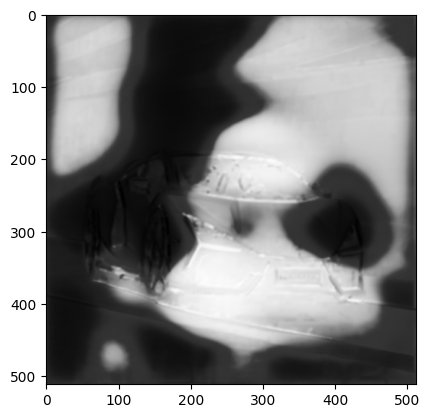

In [6]:
model = UNetModel()
checkpoint = torch.load('/content/model_unet_seg.tar')

model.load_state_dict(checkpoint)
img = Image.open('/content/car.jpg').convert('RGB')
img = img.resize((512, 512))
img = tr_img(img).unsqueeze(0)

p = model(img).squeeze(0)
x = nn.functional.sigmoid(p.permute(1, 2, 0))
x = x.detach().numpy() * 255
x = np.clip(x, 0, 255).astype('uint8')
plt.imshow(x, cmap='gray')
plt.show()